In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, return_hilbert_x0

from tools.ae_v2 import Autoencoder

from tools.ESN_v1 import ESN as RNN_SingleStep
from tools.ESN_v1_ensembleAR import ESN_ensemble as AR_RNN
from tools.AEESN_AR_v1 import AR_AERNN_ESN as AR_AERNN

from tools.hyper_param_ESN__NEWNEW import trainESN_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-13 04:35:27.953479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 04:35:27.985921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 04:35:27.986128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 04:35:27.987349: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'ESN_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_008'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/ESN_params_Search/params_search_002
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_008
data_dir_idx: 004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# GRU

In [24]:
# RNN data parameters
dt_rnn = 0.5
num_input_tsteps = 5000
T_sample_input = num_input_tsteps*dt_rnn
T_sample_output = T_sample_input
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
stddev_multiplier = 3
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'
normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                              # 'minmax' then stddev_multiplier has no effect
ESN_layers_units = [num_latent_states*200]
stateful = True
omega_in_x0 = 1.0
degree_of_connectivity_x0 = 3
rho_res_x0 = 0.8
usebias_Win = [False]
alpha_x0 = 0.99
ESN_cell_activations = ['tanh']
usebias_Wout = True

activation_post_Wout = 'linear'
use_weights_post_dense = False

vary_deg_connect = False # whether to search for degree_of_connectivity or use it as a constant

if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
    'vary_deg_connect':vary_deg_connect,
}

# saving RNN specific data
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_input_tsteps':num_input_tsteps,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':RNN_SingleStep.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
}

In [25]:
# latent_states_all = latent_states_all[0:375009]
# boundary_idx_arr = [375009]

In [26]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

In [29]:
# setting up training params
num_ensemble_mems = 5
epochs = 1
lambda_reg_x0 = 1e-7 # weight for regularizer
min_delta = 1e-6
patience = 5
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 1
fRMS_x0 = 1e-3
use_best = False

# ph computation parameters
num_runs = 50
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 5

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'use_best':use_best,
    'degree_of_connectivity_x0':degree_of_connectivity_x0,
}

In [30]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = batch_size * int((rnn_data_boundary_idx_arr[i] - begin_idx) // batch_size)
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]

    AR_testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_input[idx[num_train+num_val:num_samples]]
    AR_testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_output[idx[num_train+num_val:num_samples]]

    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [31]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  50


In [32]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [33]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [34]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (15, 5000, 5)
  training_data_rnn_output.shape :  (15, 5000, 5)
    testing_data_rnn_input.shape :  (2, 5000, 5)
   testing_data_rnn_output.shape :  (2, 5000, 5)
        val_data_rnn_input.shape :  (2, 5000, 5)
       val_data_rnn_output.shape :  (2, 5000, 5)

 AR_testing_data_rnn_input.shape :  (50, 74, 6)
AR_testing_data_rnn_output.shape :  (50, 369, 6)


In [35]:
training_data_rnn_input.dtype

dtype('float32')

In [36]:
def optim_func(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev=time_stddev,
        og_vars=og_vars,
        ESN=RNN_SingleStep,
        AR_RNN=AR_RNN,
        AR_AERNN=AR_AERNN,
        ae_net=ae_net,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
        deg_of_connectivity=degree_of_connectivity_x0,
    ):
    
    compute_time = time.time()
    
    x_in = x
    if len(x) == 5:
        x_in = [elem for elem in x]
        x_in.append(deg_of_connectivity)

    median_PH = trainESN_and_return_PH(
        x_in, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev,
        og_vars,
        ESN,
        AR_RNN,
        AR_AERNN,
        ae_net,
        mytimecallback,
        SaveLosses,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input,
        T_sample_output,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [37]:
x_bounds = [
    [1e-4, 1e-1, "log-uniform", "Real"], # fRMS
    [1e-7, 1e-3, "log-uniform", "Real"], # lambda_reg
    [0.2, 1.2, "uniform", "Real"], # rho_res
    [0.5, 2.5, "uniform", "Real"], # omega_in
    [0.5, 1.0, "uniform", "Real"], # alpha
]
if vary_deg_connect == True:
    x_bounds.append([1, 10, "uniform", "Integer"])

In [38]:
h_dims = len(x_bounds)
num_points = 10*h_dims
# num_points = 2

h_order = 0
while(True):
    if 2**(h_dims*h_order) >= num_points:
        break
    else:
        h_order += 1

print('h_dims : {} ; num_points : {} ; h_order : {}'.format(h_dims, num_points, h_order))

h_dims : 5 ; num_points : 50 ; h_order : 2


In [39]:
locs = return_hilbert_x0(num_points, h_dims, h_order)
# print(locs)
locs = np.array(locs, dtype=np.float64)
locs /= 2**h_order-1
# print(locs)

for i in range(h_dims):
    x1 = x_bounds[i][0]
    x2 = x_bounds[i][1]
    if x_bounds[i][2] == "log-uniform":
        x1 = np.log10(x1)
        x2 = np.log10(x2)
    spread = x2 - x1
    locs[:, i] *= spread
    locs[:, i] += x1
    if x_bounds[i][2] == "log-uniform":
        locs[:, i] = 10**(locs[:, i])

# print(locs)

In [40]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [41]:
print(locs)

x0 = [
    [elem2 for elem2 in elem1] for elem1 in locs
]

print(x0)

[[1.00000000e-04 1.00000000e-07 2.00000000e-01 5.00000000e-01
  5.00000000e-01]
 [1.00000000e-03 2.15443469e-06 5.33333333e-01 5.00000000e-01
  6.66666667e-01]
 [1.00000000e-03 2.15443469e-06 2.00000000e-01 5.00000000e-01
  8.33333333e-01]
 [1.00000000e-04 1.00000000e-07 5.33333333e-01 1.16666667e+00
  1.00000000e+00]
 [1.00000000e-03 1.00000000e-07 5.33333333e-01 1.83333333e+00
  1.00000000e+00]
 [1.00000000e-04 2.15443469e-06 2.00000000e-01 1.83333333e+00
  6.66666667e-01]
 [1.00000000e-04 2.15443469e-06 2.00000000e-01 2.50000000e+00
  5.00000000e-01]
 [1.00000000e-03 1.00000000e-07 8.66666667e-01 1.83333333e+00
  5.00000000e-01]
 [1.00000000e-04 1.00000000e-07 8.66666667e-01 2.50000000e+00
  8.33333333e-01]
 [1.00000000e-04 2.15443469e-06 1.20000000e+00 1.83333333e+00
  8.33333333e-01]
 [1.00000000e-03 1.00000000e-07 8.66666667e-01 1.16666667e+00
  8.33333333e-01]
 [1.00000000e-04 2.15443469e-06 8.66666667e-01 1.16666667e+00
  6.66666667e-01]
 [1.00000000e-03 1.00000000e-07 1.200000

In [42]:
acq_func = "EI"
n_initial_points = 0
n_calls = n_initial_points + len(x0) + 20

In [43]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'rho_res_bounds':x_bounds[2],
    'omega_in_bounds':x_bounds[3],
    'alpha_bounds':x_bounds[4],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
    'vary_deg_connect':vary_deg_connect,
}
if vary_deg_connect == True:
    optim_dict['vary_deg_connect'] = x_bounds[5]
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [44]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.80 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 

14 / 15 -- batch_time : 0.5709645748138428 sec
15 / 15 -- batch_time : 0.6689009666442871 sec

train_mse : 6.108300164934615e-08
val_mse : 3.225310560850403e-07
val_mse improved from inf

Total epoch computation time : 19.32500433921814 sec

test mse
1 / 2
2 / 2
test_mse : 4.62736988282586e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.84 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 5s
9 /

10 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 0s

epoch_time : 9.86366581916809 sec

val mse
1 / 2 -- batch_time : 0.6380040645599365 sec
2 / 2 -- batch_time : 0.599313497543335 sec

training mse
1 / 15 -- batch_time : 0.5836994647979736 sec
2 / 15 -- batch_time : 0.5630815029144287 sec
3 / 15 -- batch_time : 0.5956027507781982 sec
4 / 15 -- batch_time : 0.6509172916412354 sec
5 / 15 -- batch_time : 0.5200021266937256 sec
6 / 15 -- batch_time : 0.6116063594818115 sec
7 / 15 -- batch_time : 0.6087777614593506 sec
8 / 15 -- batch_time : 0.6546986103057861 sec
9 / 15 -- batch_time : 0.5633039474487305 sec
10 / 15 -- batch_time : 0.6144421100616455 sec
11 / 15 -- batch_time : 0.6119852066040039 sec
12 / 15 -- batch_time

analysis time : 14.154941320419312 s

compute_time : 0h 2m 4s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.84 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 2s
13 / 15 -- Wout batc

13 / 15 -- batch_time : 0.646263599395752 sec
14 / 15 -- batch_time : 0.6430518627166748 sec
15 / 15 -- batch_time : 0.5211639404296875 sec

train_mse : 9.90970548286896e-08
val_mse : 3.983467777857186e-07
val_mse improved from inf

Total epoch computation time : 20.409095525741577 sec

test mse
1 / 2
2 / 2
test_mse : 6.358601751799142e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.78 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
8 / 15 --

9 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.57 s -- eta : 0h 0m 0s

epoch_time : 9.638878345489502 sec

val mse
1 / 2 -- batch_time : 0.5634329319000244 sec
2 / 2 -- batch_time : 0.529695987701416 sec

training mse
1 / 15 -- batch_time : 0.5092835426330566 sec
2 / 15 -- batch_time : 0.658531665802002 sec
3 / 15 -- batch_time : 0.5933976173400879 sec
4 / 15 -- batch_time : 0.48584628105163574 sec
5 / 15 -- batch_time : 0.6602263450622559 sec
6 / 15 -- batch_time : 0.4820077419281006 sec
7 / 15 -- batch_time : 0.6126387119293213 sec
8 / 15 -- batch_time : 0.5858728885650635 sec
9 / 15 -- batch_time : 0.5514211654663086 sec
10 / 15 -- batch_time : 0.5560524463653564 sec
11 / 15 -- bat

analysis time : 13.690406084060669 s

compute_time : 0h 1m 58s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 8s
3 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.57 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 4s
9 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 2s
13 / 15 -- Wout batc

13 / 15 -- batch_time : 0.5407919883728027 sec
14 / 15 -- batch_time : 0.6026434898376465 sec
15 / 15 -- batch_time : 0.5442659854888916 sec

train_mse : 1.1942284731484658e-08
val_mse : 5.0096482260286734e-06
val_mse improved from inf

Total epoch computation time : 19.535521984100342 sec

test mse
1 / 2
2 / 2
test_mse : 5.2300418307282825e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.81 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 5s
8 /

9 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 0s

epoch_time : 9.841732501983643 sec

val mse
1 / 2 -- batch_time : 0.6109883785247803 sec
2 / 2 -- batch_time : 0.580371618270874 sec

training mse
1 / 15 -- batch_time : 0.6640298366546631 sec
2 / 15 -- batch_time : 0.6257169246673584 sec
3 / 15 -- batch_time : 0.721381664276123 sec
4 / 15 -- batch_time : 0.5074503421783447 sec
5 / 15 -- batch_time : 0.6194260120391846 sec
6 / 15 -- batch_time : 0.6549782752990723 sec
7 / 15 -- batch_time : 0.6003684997558594 sec
8 / 15 -- batch_time : 0.6550493240356445 sec
9 / 15 -- batch_time : 0.6053428649902344 sec
10 / 15 -- batch_time : 0.5843312740325928 sec
11 / 15 -- batc

analysis time : 14.08763575553894 s

compute_time : 0h 2m 3s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.77 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_

13 / 15 -- batch_time : 0.603771448135376 sec
14 / 15 -- batch_time : 0.6005408763885498 sec
15 / 15 -- batch_time : 0.5744054317474365 sec

train_mse : 1.493252638577284e-08
val_mse : 4.971752205484847e-07
val_mse improved from inf

Total epoch computation time : 19.675811529159546 sec

test mse
1 / 2
2 / 2
test_mse : 6.690865403946589e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.77 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 5s
8 / 15 -

9 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 0s

epoch_time : 9.722947597503662 sec

val mse
1 / 2 -- batch_time : 0.5514366626739502 sec
2 / 2 -- batch_time : 0.5297644138336182 sec

training mse
1 / 15 -- batch_time : 0.5240488052368164 sec
2 / 15 -- batch_time : 0.6058640480041504 sec
3 / 15 -- batch_time : 0.5702974796295166 sec
4 / 15 -- batch_time : 0.5479919910430908 sec
5 / 15 -- batch_time : 0.6169459819793701 sec
6 / 15 -- batch_time : 0.540332555770874 sec
7 / 15 -- batch_time : 0.6124322414398193 sec
8 / 15 -- batch_time : 0.568213701248169 sec
9 / 15 -- batch_time : 0.6224839687347412 sec
10 / 15 -- batch_time : 0.5519988536834717 sec
11 / 15 -- batc

analysis time : 13.808109283447266 s

compute_time : 0h 2m 0s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.722036600112915 sec
14 / 15 -- batch_time : 0.7034661769866943 sec
15 / 15 -- batch_time : 0.6009149551391602 sec

train_mse : 5.783490782581188e-09
val_mse : 7.689962697732255e-07
val_mse improved from inf

Total epoch computation time : 20.87528967857361 sec

test mse
1 / 2
2 / 2
test_mse : 9.875958877358926e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.90 s -- eta : 0h 0m 13s
2 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 11s
3 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
8 / 15 -

9 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 0s

epoch_time : 9.929613590240479 sec

val mse
1 / 2 -- batch_time : 0.5558032989501953 sec
2 / 2 -- batch_time : 0.5111591815948486 sec

training mse
1 / 15 -- batch_time : 0.656815767288208 sec
2 / 15 -- batch_time : 0.48781275749206543 sec
3 / 15 -- batch_time : 0.5185601711273193 sec
4 / 15 -- batch_time : 0.6175110340118408 sec
5 / 15 -- batch_time : 0.6121578216552734 sec
6 / 15 -- batch_time : 0.6565406322479248 sec
7 / 15 -- batch_time : 0.5769116878509521 sec
8 / 15 -- batch_time : 0.6772935390472412 sec
9 / 15 -- batch_time : 0.5394723415374756 sec
10 / 15 -- batch_time : 0.5410466194152832 sec
11 / 15 -- ba

analysis time : 13.709089517593384 s

compute_time : 0h 2m 3s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.77 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 6s
8 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 4s
11 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 2s
13 / 15 -- Wout batc

13 / 15 -- batch_time : 0.5926885604858398 sec
14 / 15 -- batch_time : 0.5998005867004395 sec
15 / 15 -- batch_time : 0.6836683750152588 sec

train_mse : 1.3433549620837464e-08
val_mse : 6.614089880230267e-06
val_mse improved from inf

Total epoch computation time : 20.04243230819702 sec

test mse
1 / 2
2 / 2
test_mse : 8.790209902187485e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.84 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 5s
8 / 15 

9 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 0s

epoch_time : 9.689782619476318 sec

val mse
1 / 2 -- batch_time : 0.5952534675598145 sec
2 / 2 -- batch_time : 0.5334837436676025 sec

training mse
1 / 15 -- batch_time : 0.5769977569580078 sec
2 / 15 -- batch_time : 0.6102516651153564 sec
3 / 15 -- batch_time : 0.5613982677459717 sec
4 / 15 -- batch_time : 0.5736870765686035 sec
5 / 15 -- batch_time : 0.5948984622955322 sec
6 / 15 -- batch_time : 0.6194274425506592 sec
7 / 15 -- batch_time : 0.6224408149719238 sec
8 / 15 -- batch_time : 0.5634555816650391 sec
9 / 15 -- batch_time : 0.5430080890655518 sec
10 / 15 -- batch_time : 0.618173360824585 sec
11 / 15 -- bat

analysis time : 13.60845685005188 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.81 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_

13 / 15 -- batch_time : 0.5255992412567139 sec
14 / 15 -- batch_time : 0.5286440849304199 sec
15 / 15 -- batch_time : 0.5805301666259766 sec

train_mse : 7.554130334597175e-08
val_mse : 2.0951635164578875e-06
val_mse improved from inf

Total epoch computation time : 19.464969158172607 sec

test mse
1 / 2
2 / 2
test_mse : 4.335879751238281e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.82 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 0s

epoch_time : 9.8139169216156 sec

val mse
1 / 2 -- batch_time : 0.5592002868652344 sec
2 / 2 -- batch_time : 0.5038483142852783 sec

training mse
1 / 15 -- batch_time : 0.532191276550293 sec
2 / 15 -- batch_time : 0.5696895122528076 sec
3 / 15 -- batch_time : 0.6093311309814453 sec
4 / 15 -- batch_time : 0.5726344585418701 sec
5 / 15 -- batch_time : 0.667849063873291 sec
6 / 15 -- batch_time : 0.5293965339660645 sec
7 / 15 -- batch_time : 0.671649694442749 sec
8 / 15 -- batch_time : 0.6147935390472412 sec
9 / 15 -- batch_time : 0.589496374130249 sec
10 / 15 -- batch_time : 0.6206626892089844 sec
11 / 15 -- batch_ti

analysis time : 13.544337034225464 s

compute_time : 0h 2m 1s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 4s
9 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6285848617553711 sec
14 / 15 -- batch_time : 0.5097343921661377 sec
15 / 15 -- batch_time : 0.6448929309844971 sec

train_mse : 1.1258716388814115e-08
val_mse : 4.529040973366705e-07
val_mse improved from inf

Total epoch computation time : 19.837663888931274 sec

test mse
1 / 2
2 / 2
test_mse : 6.911985970248224e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 9s
2 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 8s
3 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 5s
8 / 15 

9 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 4s
11 / 15 -- Wout batch_time : 0.84 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 0s

epoch_time : 10.640539407730103 sec

val mse
1 / 2 -- batch_time : 0.5855445861816406 sec
2 / 2 -- batch_time : 0.505425214767456 sec

training mse
1 / 15 -- batch_time : 0.607536792755127 sec
2 / 15 -- batch_time : 0.6647379398345947 sec
3 / 15 -- batch_time : 0.5575377941131592 sec
4 / 15 -- batch_time : 0.6882328987121582 sec
5 / 15 -- batch_time : 0.5634486675262451 sec
6 / 15 -- batch_time : 0.5458700656890869 sec
7 / 15 -- batch_time : 0.6059384346008301 sec
8 / 15 -- batch_time : 0.6321096420288086 sec
9 / 15 -- batch_time : 0.6524643898010254 sec
10 / 15 -- batch_time : 0.552504301071167 sec
11 / 15 -- batc

analysis time : 14.334456443786621 s

compute_time : 0h 2m 7s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 6s
8 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.5622920989990234 sec
14 / 15 -- batch_time : 0.5632219314575195 sec
15 / 15 -- batch_time : 0.5875816345214844 sec

train_mse : 3.126752439186475e-08
val_mse : 2.7629230636705415e-07
val_mse improved from inf

Total epoch computation time : 20.30411124229431 sec

test mse
1 / 2
2 / 2
test_mse : 2.93539117457442e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.84 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 6s
8 / 15 

9 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 4s
11 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 0s

epoch_time : 10.555792331695557 sec

val mse
1 / 2 -- batch_time : 0.6849608421325684 sec
2 / 2 -- batch_time : 0.5566980838775635 sec

training mse
1 / 15 -- batch_time : 0.6105778217315674 sec
2 / 15 -- batch_time : 0.6632480621337891 sec
3 / 15 -- batch_time : 0.6548895835876465 sec
4 / 15 -- batch_time : 0.5583961009979248 sec
5 / 15 -- batch_time : 0.6979889869689941 sec
6 / 15 -- batch_time : 0.579714298248291 sec
7 / 15 -- batch_time : 0.7019877433776855 sec
8 / 15 -- batch_time : 0.5927691459655762 sec
9 / 15 -- batch_time : 0.6314969062805176 sec
10 / 15 -- batch_time : 0.610630989074707 sec
11 / 15 -- bat

analysis time : 13.960834503173828 s

compute_time : 0h 2m 10s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.83 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.85 s -- eta : 0h 0m 11s
3 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 8s
6 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
7 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 6s
8 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 4s
11 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 2s
13 / 15 -- Wout bat

13 / 15 -- batch_time : 0.5951340198516846 sec
14 / 15 -- batch_time : 0.618401288986206 sec
15 / 15 -- batch_time : 0.6755204200744629 sec

train_mse : 2.702428005818547e-08
val_mse : 4.78657167057861e-06
val_mse improved from inf

Total epoch computation time : 20.950395345687866 sec

test mse
1 / 2
2 / 2
test_mse : 1.0808864835176735e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.76 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 6s
8 / 15 -

9 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 0s

epoch_time : 10.820337057113647 sec

val mse
1 / 2 -- batch_time : 0.6758725643157959 sec
2 / 2 -- batch_time : 0.6092278957366943 sec

training mse
1 / 15 -- batch_time : 0.584883451461792 sec
2 / 15 -- batch_time : 0.6967997550964355 sec
3 / 15 -- batch_time : 0.6943676471710205 sec
4 / 15 -- batch_time : 0.5965309143066406 sec
5 / 15 -- batch_time : 0.5387232303619385 sec
6 / 15 -- batch_time : 0.6984853744506836 sec
7 / 15 -- batch_time : 0.6296985149383545 sec
8 / 15 -- batch_time : 0.5216770172119141 sec
9 / 15 -- batch_time : 0.6459541320800781 sec
10 / 15 -- batch_time : 0.7128264904022217 sec
11 / 15 -- ba

analysis time : 14.499454259872437 s

compute_time : 0h 2m 8s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.78 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.79 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.77 s -- eta : 0h 0m 6s
8 / 15 -- Wout batch_time : 0.79 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 4s
11 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6434671878814697 sec
14 / 15 -- batch_time : 0.6549422740936279 sec
15 / 15 -- batch_time : 0.6326181888580322 sec

train_mse : 2.8047144814043654e-08
val_mse : 1.1708724301229267e-07
val_mse improved from inf

Total epoch computation time : 21.21392321586609 sec

test mse
1 / 2
2 / 2
test_mse : 1.1108623532152251e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.81 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 6s
8 / 

9 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 0s

epoch_time : 10.160515069961548 sec

val mse
1 / 2 -- batch_time : 0.618532657623291 sec
2 / 2 -- batch_time : 0.6331989765167236 sec

training mse
1 / 15 -- batch_time : 0.5085415840148926 sec
2 / 15 -- batch_time : 0.5798046588897705 sec
3 / 15 -- batch_time : 0.6725132465362549 sec
4 / 15 -- batch_time : 0.6417410373687744 sec
5 / 15 -- batch_time : 0.5025126934051514 sec
6 / 15 -- batch_time : 0.5982565879821777 sec
7 / 15 -- batch_time : 0.6193325519561768 sec
8 / 15 -- batch_time : 0.5881562232971191 sec
9 / 15 -- batch_time : 0.4925222396850586 sec
10 / 15 -- batch_time : 0.6552343368530273 sec
11 / 15 -- ba

analysis time : 14.784232139587402 s

compute_time : 0h 2m 5s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.78 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 6s
8 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 2s
13 / 15 -- Wout batc

13 / 15 -- batch_time : 0.6390120983123779 sec
14 / 15 -- batch_time : 0.5992674827575684 sec
15 / 15 -- batch_time : 0.5248110294342041 sec

train_mse : 2.8649785358917747e-08
val_mse : 1.8570521227445624e-06
val_mse improved from inf

Total epoch computation time : 20.215182065963745 sec

test mse
1 / 2
2 / 2
test_mse : 2.2672268702450538e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.57 s -- eta : 0h 0m 5s
8 / 

9 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 4s
11 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 0s

epoch_time : 10.54945707321167 sec

val mse
1 / 2 -- batch_time : 0.5601248741149902 sec
2 / 2 -- batch_time : 0.5941207408905029 sec

training mse
1 / 15 -- batch_time : 0.5600035190582275 sec
2 / 15 -- batch_time : 0.6759965419769287 sec
3 / 15 -- batch_time : 0.6217834949493408 sec
4 / 15 -- batch_time : 0.6922543048858643 sec
5 / 15 -- batch_time : 0.6354072093963623 sec
6 / 15 -- batch_time : 0.7101340293884277 sec
7 / 15 -- batch_time : 0.6116321086883545 sec
8 / 15 -- batch_time : 0.6362106800079346 sec
9 / 15 -- batch_time : 0.6018569469451904 sec
10 / 15 -- batch_time : 0.6345117092132568 sec
11 / 15 -- ba

analysis time : 14.804115295410156 s

compute_time : 0h 2m 8s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.83 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 6s
8 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 4s
11 / 15 -- Wout batch_time : 0.79 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 2s
13 / 15 -- Wout batc

13 / 15 -- batch_time : 0.6950395107269287 sec
14 / 15 -- batch_time : 0.6054713726043701 sec
15 / 15 -- batch_time : 0.587059497833252 sec

train_mse : 1.4109157859820697e-07
val_mse : 3.0844719844935753e-07
val_mse improved from inf

Total epoch computation time : 20.325496912002563 sec

test mse
1 / 2
2 / 2
test_mse : 3.373881938273371e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.82 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 0s

epoch_time : 9.573081493377686 sec

val mse
1 / 2 -- batch_time : 0.5638830661773682 sec
2 / 2 -- batch_time : 0.5565705299377441 sec

training mse
1 / 15 -- batch_time : 0.5683553218841553 sec
2 / 15 -- batch_time : 0.5887870788574219 sec
3 / 15 -- batch_time : 0.546630859375 sec
4 / 15 -- batch_time : 0.5771274566650391 sec
5 / 15 -- batch_time : 0.563056230545044 sec
6 / 15 -- batch_time : 0.5896999835968018 sec
7 / 15 -- batch_time : 0.6359727382659912 sec
8 / 15 -- batch_time : 0.5440664291381836 sec
9 / 15 -- batch_time : 0.5500295162200928 sec
10 / 15 -- batch_time : 0.5351467132568359 sec
11 / 15 -- batch_t

analysis time : 13.451998233795166 s

compute_time : 0h 1m 60s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.80 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 6s
8 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 2s
13 / 15 -- Wout bat

13 / 15 -- batch_time : 0.5983459949493408 sec
14 / 15 -- batch_time : 0.5777008533477783 sec
15 / 15 -- batch_time : 0.6128149032592773 sec

train_mse : 8.18873856284578e-06
val_mse : 1.5459833321074257e-05
val_mse improved from inf

Total epoch computation time : 20.261714935302734 sec

test mse
1 / 2
2 / 2
test_mse : 1.5145835277508013e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.84 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 0s

epoch_time : 10.1712965965271 sec

val mse
1 / 2 -- batch_time : 0.588860034942627 sec
2 / 2 -- batch_time : 0.5514564514160156 sec

training mse
1 / 15 -- batch_time : 0.5737590789794922 sec
2 / 15 -- batch_time : 0.5478451251983643 sec
3 / 15 -- batch_time : 0.7003395557403564 sec
4 / 15 -- batch_time : 0.668147087097168 sec
5 / 15 -- batch_time : 0.6753692626953125 sec
6 / 15 -- batch_time : 0.7375497817993164 sec
7 / 15 -- batch_time : 0.5718386173248291 sec
8 / 15 -- batch_time : 0.5388858318328857 sec
9 / 15 -- batch_time : 0.6215429306030273 sec
10 / 15 -- batch_time : 0.6577003002166748 sec
11 / 15 -- batch

analysis time : 13.908970355987549 s

compute_time : 0h 2m 3s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.76 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.57 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.57 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.5671710968017578 sec
14 / 15 -- batch_time : 0.5672636032104492 sec
15 / 15 -- batch_time : 0.5009148120880127 sec

train_mse : 2.905894509315961e-07
val_mse : 6.794297412682226e-06
val_mse improved from inf

Total epoch computation time : 19.241304636001587 sec

test mse
1 / 2
2 / 2
test_mse : 7.491402357118204e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.57 s -- eta : 0h 0m 8s
3 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 5s
8 / 15 

9 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.57 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 0s

epoch_time : 9.45691204071045 sec

val mse
1 / 2 -- batch_time : 0.6140379905700684 sec
2 / 2 -- batch_time : 0.527625322341919 sec

training mse
1 / 15 -- batch_time : 0.6116142272949219 sec
2 / 15 -- batch_time : 0.6903321743011475 sec
3 / 15 -- batch_time : 0.5591449737548828 sec
4 / 15 -- batch_time : 0.6326544284820557 sec
5 / 15 -- batch_time : 0.5783932209014893 sec
6 / 15 -- batch_time : 0.6878006458282471 sec
7 / 15 -- batch_time : 0.6296076774597168 sec
8 / 15 -- batch_time : 0.6660451889038086 sec
9 / 15 -- batch_time : 0.6452276706695557 sec
10 / 15 -- batch_time : 0.543475866317749 sec
11 / 15 -- batch

analysis time : 13.825458765029907 s

compute_time : 0h 1m 60s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.77 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 2s
13 / 15 -- Wout batc

13 / 15 -- batch_time : 0.615936279296875 sec
14 / 15 -- batch_time : 0.70662522315979 sec
15 / 15 -- batch_time : 0.6762938499450684 sec

train_mse : 7.4511864416611695e-06
val_mse : 1.4150690503811347e-05
val_mse improved from inf

Total epoch computation time : 20.60205864906311 sec

test mse
1 / 2
2 / 2
test_mse : 1.3030637774136267e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.98 s -- eta : 0h 0m 14s
2 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 11s
3 / 15 -- Wout batch_time : 0.76 s -- eta : 0h 0m 10s
4 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 9s
5 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 8s
6 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 7s
7 / 15 -- Wout batch_time : 0.77 s -- eta : 0h 0m 6s
8 / 15

9 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 0s

epoch_time : 10.220688581466675 sec

val mse
1 / 2 -- batch_time : 0.6069357395172119 sec
2 / 2 -- batch_time : 0.5200366973876953 sec

training mse
1 / 15 -- batch_time : 0.5876297950744629 sec
2 / 15 -- batch_time : 0.49042272567749023 sec
3 / 15 -- batch_time : 0.5929150581359863 sec
4 / 15 -- batch_time : 0.527430534362793 sec
5 / 15 -- batch_time : 0.6352946758270264 sec
6 / 15 -- batch_time : 0.6230924129486084 sec
7 / 15 -- batch_time : 0.632849931716919 sec
8 / 15 -- batch_time : 0.6078488826751709 sec
9 / 15 -- batch_time : 0.6107792854309082 sec
10 / 15 -- batch_time : 0.5712120532989502 sec
11 / 15 -- ba

analysis time : 13.52312970161438 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.81 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_

13 / 15 -- batch_time : 0.6693081855773926 sec
14 / 15 -- batch_time : 0.6027026176452637 sec
15 / 15 -- batch_time : 0.6398484706878662 sec

train_mse : 2.400621070819398e-07
val_mse : 1.4657505900572687e-05
val_mse improved from inf

Total epoch computation time : 20.28763771057129 sec

test mse
1 / 2
2 / 2
test_mse : 2.761656752880981e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.80 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.76 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 0s

epoch_time : 9.731499671936035 sec

val mse
1 / 2 -- batch_time : 0.6153104305267334 sec
2 / 2 -- batch_time : 0.6431722640991211 sec

training mse
1 / 15 -- batch_time : 0.5775866508483887 sec
2 / 15 -- batch_time : 0.5603718757629395 sec
3 / 15 -- batch_time : 0.5280575752258301 sec
4 / 15 -- batch_time : 0.5738253593444824 sec
5 / 15 -- batch_time : 0.6162049770355225 sec
6 / 15 -- batch_time : 0.5985629558563232 sec
7 / 15 -- batch_time : 0.6905746459960938 sec
8 / 15 -- batch_time : 0.6318702697753906 sec
9 / 15 -- batch_time : 0.5979013442993164 sec
10 / 15 -- batch_time : 0.6130940914154053 sec
11 / 15 -- ba

analysis time : 13.449669361114502 s

compute_time : 0h 2m 1s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6501560211181641 sec
14 / 15 -- batch_time : 0.6282744407653809 sec
15 / 15 -- batch_time : 0.6368603706359863 sec

train_mse : 1.2125648390792778e-05
val_mse : 1.9715243070095312e-05
val_mse improved from inf

Total epoch computation time : 19.565738439559937 sec

test mse
1 / 2
2 / 2
test_mse : 2.0111684079893166e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.80 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 5s
8 / 

9 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 0s

epoch_time : 9.581913232803345 sec

val mse
1 / 2 -- batch_time : 0.6011757850646973 sec
2 / 2 -- batch_time : 0.635474681854248 sec

training mse
1 / 15 -- batch_time : 0.6031744480133057 sec
2 / 15 -- batch_time : 0.6175789833068848 sec
3 / 15 -- batch_time : 0.529188871383667 sec
4 / 15 -- batch_time : 0.586219310760498 sec
5 / 15 -- batch_time : 0.5290012359619141 sec
6 / 15 -- batch_time : 0.5498809814453125 sec
7 / 15 -- batch_time : 0.614771842956543 sec
8 / 15 -- batch_time : 0.6283349990844727 sec
9 / 15 -- batch_time : 0.6036713123321533 sec
10 / 15 -- batch_time : 0.6157183647155762 sec
11 / 15 -- batch_

analysis time : 13.514418840408325 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6234481334686279 sec
14 / 15 -- batch_time : 0.5475735664367676 sec
15 / 15 -- batch_time : 0.5584995746612549 sec

train_mse : 5.312278669104368e-06
val_mse : 1.4906497654010309e-05
val_mse improved from inf

Total epoch computation time : 19.539705753326416 sec

test mse
1 / 2
2 / 2
test_mse : 1.952727427578793e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 9s
2 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 5s
8 / 15 

9 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 0s

epoch_time : 10.162942886352539 sec

val mse
1 / 2 -- batch_time : 0.560600757598877 sec
2 / 2 -- batch_time : 0.618394136428833 sec

training mse
1 / 15 -- batch_time : 0.6011557579040527 sec
2 / 15 -- batch_time : 0.6153388023376465 sec
3 / 15 -- batch_time : 0.5194294452667236 sec
4 / 15 -- batch_time : 0.6251280307769775 sec
5 / 15 -- batch_time : 0.5980393886566162 sec
6 / 15 -- batch_time : 0.5927178859710693 sec
7 / 15 -- batch_time : 0.60679030418396 sec
8 / 15 -- batch_time : 0.619304895401001 sec
9 / 15 -- batch_time : 0.5505955219268799 sec
10 / 15 -- batch_time : 0.5629880428314209 sec
11 / 15 -- batch_

analysis time : 13.516057968139648 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.76 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.5312855243682861 sec
14 / 15 -- batch_time : 0.6213266849517822 sec
15 / 15 -- batch_time : 0.5739684104919434 sec

train_mse : 5.73888650023946e-07
val_mse : 1.7454794829063758e-05
val_mse improved from inf

Total epoch computation time : 20.23464322090149 sec

test mse
1 / 2
2 / 2
test_mse : 3.8461723917748714e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.78 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 5s
8 / 15 

9 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 0s

epoch_time : 9.933913469314575 sec

val mse
1 / 2 -- batch_time : 0.5683531761169434 sec
2 / 2 -- batch_time : 0.5842444896697998 sec

training mse
1 / 15 -- batch_time : 0.6391708850860596 sec
2 / 15 -- batch_time : 0.5273630619049072 sec
3 / 15 -- batch_time : 0.6187944412231445 sec
4 / 15 -- batch_time : 0.6321377754211426 sec
5 / 15 -- batch_time : 0.579714298248291 sec
6 / 15 -- batch_time : 0.617551326751709 sec
7 / 15 -- batch_time : 0.6426866054534912 sec
8 / 15 -- batch_time : 0.629584550857544 sec
9 / 15 -- batch_time : 0.6161158084869385 sec
10 / 15 -- batch_time : 0.5659060478210449 sec
11 / 15 -- batch

analysis time : 13.556279420852661 s

compute_time : 0h 2m 1s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 8s
3 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.679718017578125 sec
14 / 15 -- batch_time : 0.5410802364349365 sec
15 / 15 -- batch_time : 0.662773847579956 sec

train_mse : 2.1351577809506728e-07
val_mse : 1.1059696348070247e-05
val_mse improved from inf

Total epoch computation time : 20.09471893310547 sec

test mse
1 / 2
2 / 2
test_mse : 1.3460692684930109e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.85 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 5s
8 / 15 

9 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 0s

epoch_time : 9.568869590759277 sec

val mse
1 / 2 -- batch_time : 0.5606520175933838 sec
2 / 2 -- batch_time : 0.49149394035339355 sec

training mse
1 / 15 -- batch_time : 0.6173200607299805 sec
2 / 15 -- batch_time : 0.588221549987793 sec
3 / 15 -- batch_time : 0.5629549026489258 sec
4 / 15 -- batch_time : 0.5293009281158447 sec
5 / 15 -- batch_time : 0.6090967655181885 sec
6 / 15 -- batch_time : 0.657768726348877 sec
7 / 15 -- batch_time : 0.6220192909240723 sec
8 / 15 -- batch_time : 0.614464521408081 sec
9 / 15 -- batch_time : 0.5933914184570312 sec
10 / 15 -- batch_time : 0.5935523509979248 sec
11 / 15 -- batc

analysis time : 13.878384590148926 s

compute_time : 0h 2m 1s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6435463428497314 sec
14 / 15 -- batch_time : 0.5674154758453369 sec
15 / 15 -- batch_time : 0.6011626720428467 sec

train_mse : 9.161350711413735e-06
val_mse : 1.8202518731413875e-05
val_mse improved from inf

Total epoch computation time : 19.61888837814331 sec

test mse
1 / 2
2 / 2
test_mse : 1.6113035371745354e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.80 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 0s

epoch_time : 9.883428573608398 sec

val mse
1 / 2 -- batch_time : 0.6745040416717529 sec
2 / 2 -- batch_time : 0.5001821517944336 sec

training mse
1 / 15 -- batch_time : 0.5712895393371582 sec
2 / 15 -- batch_time : 0.568406343460083 sec
3 / 15 -- batch_time : 0.5945091247558594 sec
4 / 15 -- batch_time : 0.48422718048095703 sec
5 / 15 -- batch_time : 0.6172695159912109 sec
6 / 15 -- batch_time : 0.5954902172088623 sec
7 / 15 -- batch_time : 0.5978798866271973 sec
8 / 15 -- batch_time : 0.6199295520782471 sec
9 / 15 -- batch_time : 0.6336832046508789 sec
10 / 15 -- batch_time : 0.6995892524719238 sec
11 / 15 -- ba

analysis time : 13.663971185684204 s

compute_time : 0h 2m 3s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.5490124225616455 sec
14 / 15 -- batch_time : 0.683882474899292 sec
15 / 15 -- batch_time : 0.5777409076690674 sec

train_mse : 6.776742823907019e-06
val_mse : 1.6220179759329767e-05
val_mse improved from inf

Total epoch computation time : 20.222927570343018 sec

test mse
1 / 2
2 / 2
test_mse : 1.6007478052415536e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 0s

epoch_time : 10.01693320274353 sec

val mse
1 / 2 -- batch_time : 0.5684056282043457 sec
2 / 2 -- batch_time : 0.6247994899749756 sec

training mse
1 / 15 -- batch_time : 0.4940328598022461 sec
2 / 15 -- batch_time : 0.6513516902923584 sec
3 / 15 -- batch_time : 0.6267118453979492 sec
4 / 15 -- batch_time : 0.6027133464813232 sec
5 / 15 -- batch_time : 0.5769138336181641 sec
6 / 15 -- batch_time : 0.6293010711669922 sec
7 / 15 -- batch_time : 0.5648355484008789 sec
8 / 15 -- batch_time : 0.6493246555328369 sec
9 / 15 -- batch_time : 0.5176072120666504 sec
10 / 15 -- batch_time : 0.6130363941192627 sec
11 / 15 -- ba

analysis time : 13.983400821685791 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 9s
2 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_

13 / 15 -- batch_time : 0.5125739574432373 sec
14 / 15 -- batch_time : 0.610492467880249 sec
15 / 15 -- batch_time : 0.5668222904205322 sec

train_mse : 2.2874160994964163e-07
val_mse : 6.636893850497927e-06
val_mse improved from inf

Total epoch computation time : 19.095966815948486 sec

test mse
1 / 2
2 / 2
test_mse : 7.904065569164231e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.78 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 5s
8 / 15 

9 / 15 -- Wout batch_time : 0.57 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.57 s -- eta : 0h 0m 2s
12 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 0s

epoch_time : 9.037915706634521 sec

val mse
1 / 2 -- batch_time : 0.5343139171600342 sec
2 / 2 -- batch_time : 0.550119161605835 sec

training mse
1 / 15 -- batch_time : 0.6849548816680908 sec
2 / 15 -- batch_time : 0.5243344306945801 sec
3 / 15 -- batch_time : 0.48956894874572754 sec
4 / 15 -- batch_time : 0.5650913715362549 sec
5 / 15 -- batch_time : 0.5272948741912842 sec
6 / 15 -- batch_time : 0.4963853359222412 sec
7 / 15 -- batch_time : 0.5146152973175049 sec
8 / 15 -- batch_time : 0.5662648677825928 sec
9 / 15 -- batch_time : 0.5863871574401855 sec
10 / 15 -- batch_time : 0.5010743141174316 sec
11 / 15 -- ba

analysis time : 13.904002666473389 s

compute_time : 0h 1m 58s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 9s
2 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 8s
3 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.5691492557525635 sec
14 / 15 -- batch_time : 0.5907745361328125 sec
15 / 15 -- batch_time : 0.5347139835357666 sec

train_mse : 6.111784955464827e-07
val_mse : 3.6348584444567678e-06
val_mse improved from inf

Total epoch computation time : 20.67025661468506 sec

test mse
1 / 2
2 / 2
test_mse : 5.543948475406069e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.79 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 5s
8 / 15 

9 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 0s

epoch_time : 9.743462562561035 sec

val mse
1 / 2 -- batch_time : 0.6199297904968262 sec
2 / 2 -- batch_time : 0.5584323406219482 sec

training mse
1 / 15 -- batch_time : 0.6450557708740234 sec
2 / 15 -- batch_time : 0.5997588634490967 sec
3 / 15 -- batch_time : 0.6811027526855469 sec
4 / 15 -- batch_time : 0.5753529071807861 sec
5 / 15 -- batch_time : 0.7014195919036865 sec
6 / 15 -- batch_time : 0.5833284854888916 sec
7 / 15 -- batch_time : 0.6177353858947754 sec
8 / 15 -- batch_time : 0.537971019744873 sec
9 / 15 -- batch_time : 0.6466073989868164 sec
10 / 15 -- batch_time : 0.6307144165039062 sec
11 / 15 -- bat

analysis time : 13.801640033721924 s

compute_time : 0h 2m 3s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6446714401245117 sec
14 / 15 -- batch_time : 0.6396923065185547 sec
15 / 15 -- batch_time : 0.6604461669921875 sec

train_mse : 2.492385980682835e-06
val_mse : 2.0444546805720165e-05
val_mse improved from inf

Total epoch computation time : 19.815446376800537 sec

test mse
1 / 2
2 / 2
test_mse : 3.870521061344334e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.82 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 0s

epoch_time : 9.82137680053711 sec

val mse
1 / 2 -- batch_time : 0.5698895454406738 sec
2 / 2 -- batch_time : 0.5120313167572021 sec

training mse
1 / 15 -- batch_time : 0.48279762268066406 sec
2 / 15 -- batch_time : 0.6276993751525879 sec
3 / 15 -- batch_time : 0.6389420032501221 sec
4 / 15 -- batch_time : 0.5707788467407227 sec
5 / 15 -- batch_time : 0.5735337734222412 sec
6 / 15 -- batch_time : 0.5382509231567383 sec
7 / 15 -- batch_time : 0.6242313385009766 sec
8 / 15 -- batch_time : 0.6082522869110107 sec
9 / 15 -- batch_time : 0.5588290691375732 sec
10 / 15 -- batch_time : 0.6416656970977783 sec
11 / 15 -- ba

analysis time : 13.613834857940674 s

compute_time : 0h 2m 1s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 9s
2 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_

13 / 15 -- batch_time : 0.602365255355835 sec
14 / 15 -- batch_time : 0.5718019008636475 sec
15 / 15 -- batch_time : 0.5959916114807129 sec

train_mse : 1.3563066242265145e-06
val_mse : 1.8154818292259733e-05
val_mse improved from inf

Total epoch computation time : 19.71818518638611 sec

test mse
1 / 2
2 / 2
test_mse : 3.3642470071981734e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 0s

epoch_time : 9.813647031784058 sec

val mse
1 / 2 -- batch_time : 0.5716586112976074 sec
2 / 2 -- batch_time : 0.5270135402679443 sec

training mse
1 / 15 -- batch_time : 0.6119017601013184 sec
2 / 15 -- batch_time : 0.5655086040496826 sec
3 / 15 -- batch_time : 0.6325819492340088 sec
4 / 15 -- batch_time : 0.6013669967651367 sec
5 / 15 -- batch_time : 0.6917519569396973 sec
6 / 15 -- batch_time : 0.5914733409881592 sec
7 / 15 -- batch_time : 0.5374038219451904 sec
8 / 15 -- batch_time : 0.6064844131469727 sec
9 / 15 -- batch_time : 0.613210916519165 sec
10 / 15 -- batch_time : 0.625870943069458 sec
11 / 15 -- batc

analysis time : 13.570716619491577 s

compute_time : 0h 2m 3s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6670372486114502 sec
14 / 15 -- batch_time : 0.5879700183868408 sec
15 / 15 -- batch_time : 0.5612962245941162 sec

train_mse : 6.526763399961055e-06
val_mse : 2.3380444645226817e-05
val_mse improved from inf

Total epoch computation time : 19.931244373321533 sec

test mse
1 / 2
2 / 2
test_mse : 3.199760556071851e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.88 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 5s
8 / 1

9 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 0s

epoch_time : 9.748765707015991 sec

val mse
1 / 2 -- batch_time : 0.6350340843200684 sec
2 / 2 -- batch_time : 0.5530848503112793 sec

training mse
1 / 15 -- batch_time : 0.6076006889343262 sec
2 / 15 -- batch_time : 0.6248049736022949 sec
3 / 15 -- batch_time : 0.5906398296356201 sec
4 / 15 -- batch_time : 0.6784548759460449 sec
5 / 15 -- batch_time : 0.7113537788391113 sec
6 / 15 -- batch_time : 0.6520037651062012 sec
7 / 15 -- batch_time : 0.6511478424072266 sec
8 / 15 -- batch_time : 0.6314280033111572 sec
9 / 15 -- batch_time : 0.6327602863311768 sec
10 / 15 -- batch_time : 0.6966137886047363 sec
11 / 15 -- ba

analysis time : 13.558910608291626 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.82 s -- eta : 0h 0m 12s
2 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 2s
13 / 15 -- Wout batc

13 / 15 -- batch_time : 0.5926532745361328 sec
14 / 15 -- batch_time : 0.6328942775726318 sec
15 / 15 -- batch_time : 0.6120855808258057 sec

train_mse : 2.553305732059623e-06
val_mse : 1.663661242901071e-05
val_mse improved from inf

Total epoch computation time : 20.16840410232544 sec

test mse
1 / 2
2 / 2
test_mse : 3.277855552141773e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.77 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.58 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 5s
8 / 15 -

9 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 0s

epoch_time : 9.597006559371948 sec

val mse
1 / 2 -- batch_time : 0.6788575649261475 sec
2 / 2 -- batch_time : 0.5132715702056885 sec

training mse
1 / 15 -- batch_time : 0.6548264026641846 sec
2 / 15 -- batch_time : 0.5502078533172607 sec
3 / 15 -- batch_time : 0.5889678001403809 sec
4 / 15 -- batch_time : 0.575732946395874 sec
5 / 15 -- batch_time : 0.6674742698669434 sec
6 / 15 -- batch_time : 0.5251762866973877 sec
7 / 15 -- batch_time : 0.6037771701812744 sec
8 / 15 -- batch_time : 0.5903990268707275 sec
9 / 15 -- batch_time : 0.5602421760559082 sec
10 / 15 -- batch_time : 0.5268776416778564 sec
11 / 15 -- bat

analysis time : 13.771098136901855 s

compute_time : 0h 2m 4s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 8s
3 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6267855167388916 sec
14 / 15 -- batch_time : 0.5553653240203857 sec
15 / 15 -- batch_time : 0.607769250869751 sec

train_mse : 6.717113024024e-07
val_mse : 1.4163058423832808e-05
val_mse improved from inf

Total epoch computation time : 20.14812469482422 sec

test mse
1 / 2
2 / 2
test_mse : 1.63649682463074e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 5s
8 / 15 -- Wo

9 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 0s

epoch_time : 9.86289930343628 sec

val mse
1 / 2 -- batch_time : 0.6211771965026855 sec
2 / 2 -- batch_time : 0.5332260131835938 sec

training mse
1 / 15 -- batch_time : 0.6230001449584961 sec
2 / 15 -- batch_time : 0.6078019142150879 sec
3 / 15 -- batch_time : 0.5574979782104492 sec
4 / 15 -- batch_time : 0.6190495491027832 sec
5 / 15 -- batch_time : 0.6473541259765625 sec
6 / 15 -- batch_time : 0.6165525913238525 sec
7 / 15 -- batch_time : 0.6033375263214111 sec
8 / 15 -- batch_time : 0.6900687217712402 sec
9 / 15 -- batch_time : 0.5522518157958984 sec
10 / 15 -- batch_time : 0.634505033493042 sec
11 / 15 -- batc

analysis time : 13.791003704071045 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 9s
2 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 8s
3 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.76 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_

13 / 15 -- batch_time : 0.6578328609466553 sec
14 / 15 -- batch_time : 0.5629866123199463 sec
15 / 15 -- batch_time : 0.6105091571807861 sec

train_mse : 7.105395989507693e-07
val_mse : 1.6233726782388658e-05
val_mse improved from inf

Total epoch computation time : 20.389097213745117 sec

test mse
1 / 2
2 / 2
test_mse : 2.258740114768898e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 0s

epoch_time : 9.658845663070679 sec

val mse
1 / 2 -- batch_time : 0.5613112449645996 sec
2 / 2 -- batch_time : 0.6316986083984375 sec

training mse
1 / 15 -- batch_time : 0.5615592002868652 sec
2 / 15 -- batch_time : 0.6187100410461426 sec
3 / 15 -- batch_time : 0.5999822616577148 sec
4 / 15 -- batch_time : 0.6769988536834717 sec
5 / 15 -- batch_time : 0.6526610851287842 sec
6 / 15 -- batch_time : 0.6506061553955078 sec
7 / 15 -- batch_time : 0.6078393459320068 sec
8 / 15 -- batch_time : 0.632831335067749 sec
9 / 15 -- batch_time : 0.5431652069091797 sec
10 / 15 -- batch_time : 0.6538050174713135 sec
11 / 15 -- bat

analysis time : 13.670194149017334 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 4s
9 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6494834423065186 sec
14 / 15 -- batch_time : 0.695946216583252 sec
15 / 15 -- batch_time : 0.6205906867980957 sec

train_mse : 1.5939079313890642e-06
val_mse : 1.6946481053992102e-05
val_mse improved from inf

Total epoch computation time : 20.473974466323853 sec

test mse
1 / 2
2 / 2
test_mse : 2.2362334732406453e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.76 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 5s
8 / 1

9 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 0s

epoch_time : 10.094574928283691 sec

val mse
1 / 2 -- batch_time : 0.556797981262207 sec
2 / 2 -- batch_time : 0.611809253692627 sec

training mse
1 / 15 -- batch_time : 0.5836334228515625 sec
2 / 15 -- batch_time : 0.5148952007293701 sec
3 / 15 -- batch_time : 0.571605920791626 sec
4 / 15 -- batch_time : 0.6342122554779053 sec
5 / 15 -- batch_time : 0.5411133766174316 sec
6 / 15 -- batch_time : 0.5646340847015381 sec
7 / 15 -- batch_time : 0.6865227222442627 sec
8 / 15 -- batch_time : 0.5997023582458496 sec
9 / 15 -- batch_time : 0.5161948204040527 sec
10 / 15 -- batch_time : 0.6703317165374756 sec
11 / 15 -- batc

analysis time : 13.804647445678711 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
6 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.73 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.5852260589599609 sec
14 / 15 -- batch_time : 0.5239319801330566 sec
15 / 15 -- batch_time : 0.5889339447021484 sec

train_mse : 5.3726520794346776e-06
val_mse : 1.6661472045598202e-05
val_mse improved from inf

Total epoch computation time : 19.434267282485962 sec

test mse
1 / 2
2 / 2
test_mse : 3.079240877923439e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.79 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 5s
8 / 

9 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 0s

epoch_time : 10.242421388626099 sec

val mse
1 / 2 -- batch_time : 0.650773286819458 sec
2 / 2 -- batch_time : 0.5413169860839844 sec

training mse
1 / 15 -- batch_time : 0.599564790725708 sec
2 / 15 -- batch_time : 0.5864615440368652 sec
3 / 15 -- batch_time : 0.6277713775634766 sec
4 / 15 -- batch_time : 0.5946574211120605 sec
5 / 15 -- batch_time : 0.5659818649291992 sec
6 / 15 -- batch_time : 0.563056468963623 sec
7 / 15 -- batch_time : 0.551422119140625 sec
8 / 15 -- batch_time : 0.6090993881225586 sec
9 / 15 -- batch_time : 0.6763179302215576 sec
10 / 15 -- batch_time : 0.5872457027435303 sec
11 / 15 -- batch

analysis time : 13.557600259780884 s

compute_time : 0h 2m 2s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.78 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.71 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 6s
8 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.69 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.6002323627471924 sec
14 / 15 -- batch_time : 0.49786901473999023 sec
15 / 15 -- batch_time : 0.6963233947753906 sec

train_mse : 7.11962039190439e-07
val_mse : 1.724534786262666e-05
val_mse improved from inf

Total epoch computation time : 20.284493684768677 sec

test mse
1 / 2
2 / 2
test_mse : 3.354903536489928e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.75 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
4 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 7s
5 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 5s
8 / 15 

9 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.62 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.65 s -- eta : 0h 0m 0s

epoch_time : 10.027023553848267 sec

val mse
1 / 2 -- batch_time : 0.6075119972229004 sec
2 / 2 -- batch_time : 0.5504226684570312 sec

training mse
1 / 15 -- batch_time : 0.6931807994842529 sec
2 / 15 -- batch_time : 0.6100959777832031 sec
3 / 15 -- batch_time : 0.7219462394714355 sec
4 / 15 -- batch_time : 0.6894104480743408 sec
5 / 15 -- batch_time : 0.5751791000366211 sec
6 / 15 -- batch_time : 0.7047080993652344 sec
7 / 15 -- batch_time : 0.6771738529205322 sec
8 / 15 -- batch_time : 0.7178192138671875 sec
9 / 15 -- batch_time : 0.6136152744293213 sec
10 / 15 -- batch_time : 0.5302855968475342 sec
11 / 15 -- b

analysis time : 13.647146224975586 s

compute_time : 0h 2m 5s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.74 s -- eta : 0h 0m 10s
2 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 9s
3 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.63 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 5s
8 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 5s
9 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.64 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch

13 / 15 -- batch_time : 0.641176700592041 sec
14 / 15 -- batch_time : 0.5870521068572998 sec
15 / 15 -- batch_time : 0.6021947860717773 sec

train_mse : 3.962503266545052e-06
val_mse : 1.8212775330539444e-05
val_mse improved from inf

Total epoch computation time : 19.80317974090576 sec

test mse
1 / 2
2 / 2
test_mse : 2.0259724919924338e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 0.80 s -- eta : 0h 0m 11s
2 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 10s
3 / 15 -- Wout batch_time : 0.66 s -- eta : 0h 0m 9s
4 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 8s
5 / 15 -- Wout batch_time : 0.70 s -- eta : 0h 0m 7s
6 / 15 -- Wout batch_time : 0.72 s -- eta : 0h 0m 6s
7 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 5s
8 / 15

9 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 4s
10 / 15 -- Wout batch_time : 0.59 s -- eta : 0h 0m 3s
11 / 15 -- Wout batch_time : 0.60 s -- eta : 0h 0m 3s
12 / 15 -- Wout batch_time : 0.68 s -- eta : 0h 0m 2s
13 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 1s
14 / 15 -- Wout batch_time : 0.67 s -- eta : 0h 0m 1s
15 / 15 -- Wout batch_time : 0.61 s -- eta : 0h 0m 0s

epoch_time : 10.011151552200317 sec

val mse
1 / 2 -- batch_time : 0.5961892604827881 sec
2 / 2 -- batch_time : 0.5908517837524414 sec

training mse
1 / 15 -- batch_time : 0.5887348651885986 sec
2 / 15 -- batch_time : 0.6643218994140625 sec
3 / 15 -- batch_time : 0.5351476669311523 sec
4 / 15 -- batch_time : 0.5895838737487793 sec
5 / 15 -- batch_time : 0.626086950302124 sec
6 / 15 -- batch_time : 0.6355278491973877 sec
7 / 15 -- batch_time : 0.5038096904754639 sec
8 / 15 -- batch_time : 0.530437707901001 sec
9 / 15 -- batch_time : 0.5710744857788086 sec
10 / 15 -- batch_time : 0.5978062152862549 sec
11 / 15 -- bat

analysis time : 13.502662420272827 s

compute_time : 0h 2m 2s


In [45]:
res

          fun: -3.3994079077004753
    func_vals: array([-1.06993317, -1.23245466, -1.13765046, -0.92095513, -1.27308503,
       -0.88032476, -0.94804205, -2.01797521, -0.88032476, -1.20536774,
       -1.63875839, -1.08347662, -1.59812802, -1.50332382, -1.09702008,
       -1.20536774, -1.20536774, -1.46269344, -1.39497615, -0.94804205,
       -0.89386821, -1.13765046, -1.20536774, -0.88032476, -0.89386821,
       -1.84191026, -1.89608409, -1.51686727, -1.89608409, -1.85545372,
       -1.7335626 , -1.90962755, -2.53262661, -2.0856925 , -2.4378224 ,
       -2.11277942, -2.57325698, -2.57325698, -2.45136586, -2.58680044,
       -2.30238783, -2.42427895, -2.09923596, -2.65451773, -1.92317101,
       -1.80127989, -1.95025792, -1.74710606, -1.81482335, -2.12632287,
       -3.39940791, -2.11277942, -2.73577848, -2.58680044, -2.45136586,
       -2.09923596, -3.12853875, -3.06082146, -2.78995231, -2.9524738 ,
       -2.81703922, -2.74932193, -2.70869156, -2.92538688, -2.61388736,
       -2.5190

In [46]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [47]:
optim_idx

50

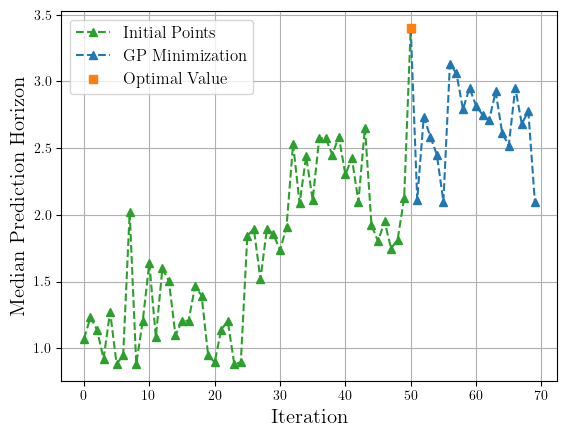

In [48]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.plot(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.plot(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

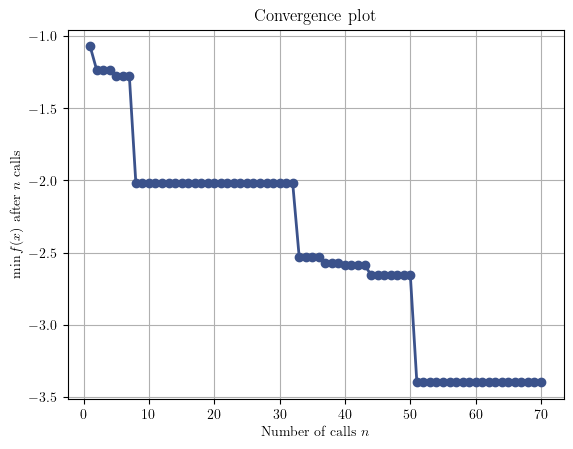

In [49]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [50]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

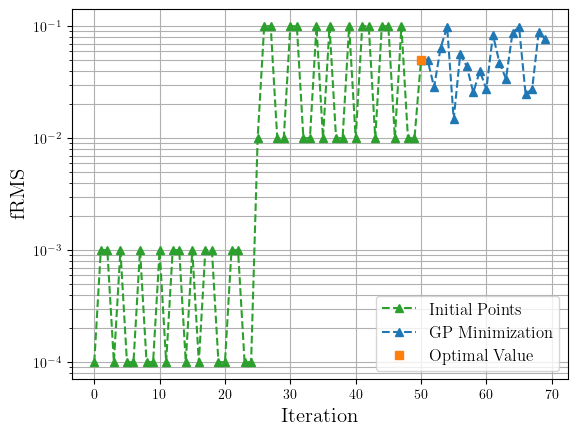

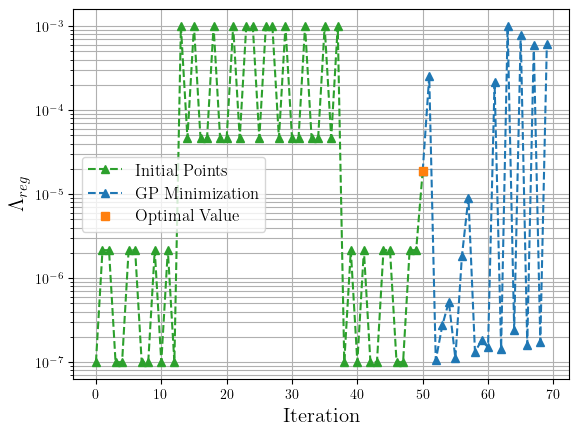

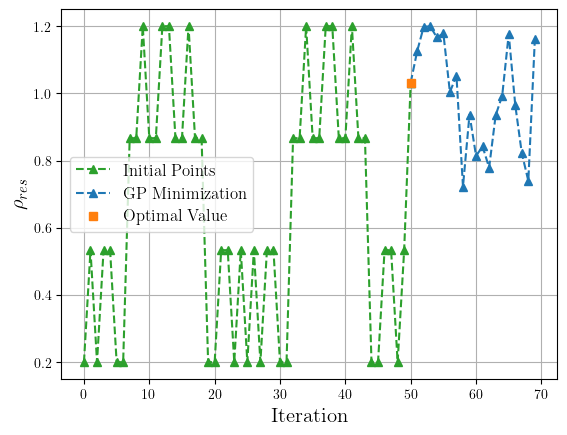

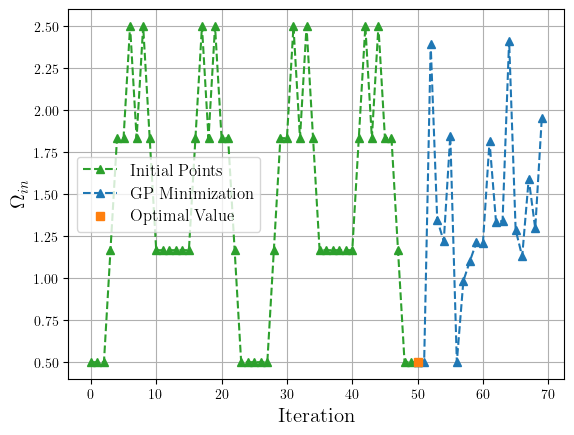

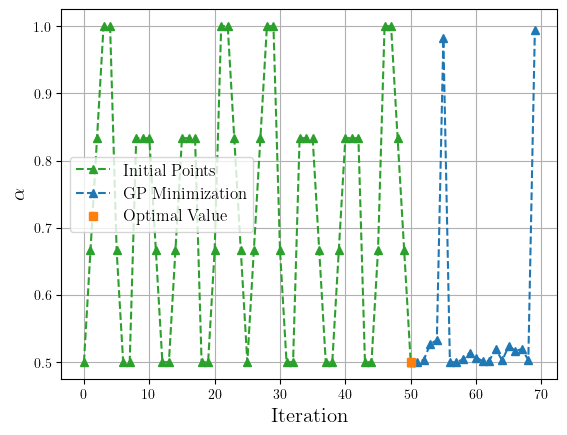

In [51]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$\rho_{res}$', 'rho_res', plt.plot],
    [r'$\Omega_{in}$', 'omega_in', plt.plot],
    [r'$\alpha$', 'alpha', plt.plot],
]
if vary_deg_connect == True:
    xoptim_names.append(
        [r'Degree of Connectivity', 'deg_of_connectivity', plt.plot]
    )

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [52]:
dir_list = os.listdir(dir_name_rnn+'/tested_rnn')
# dir_list

In [53]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_rnn/'+dir_name+'/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [54]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [55]:
idx, dir_list[idx[0]]

(array([18]), 'test_rnn_050')

In [56]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

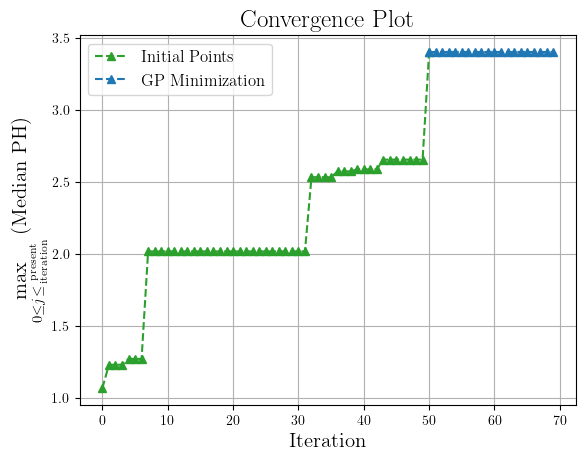

In [57]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.plot(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.plot(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation